# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv("Udacity_AZDIAS_Subset.csv", delimiter=";")

# Load in the feature summary file.
feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv", delimiter=";")

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print(azdias.shape)
display(azdias.head())

(891221, 85)


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [4]:
print(feat_info.shape)
display(feat_info.head())

(85, 4)


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [5]:
feat_info.dtypes

attribute             object
information_level     object
type                  object
missing_or_unknown    object
dtype: object

In [6]:
# str to list 
feat_info['missing_or_unknown'] = feat_info['missing_or_unknown'].apply(lambda x: x[1:-1].split(','))

In [7]:
display(feat_info.head())

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1, 0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1, 0, 9]"
2,ANREDE_KZ,person,categorical,"[-1, 0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [8]:
# Identify missing or unknown data values and convert them to NaNs.

#########################
# for n, m in zip(feat_info['attribute'], feat_info['missing_or_unknown']):
#     if m[0] != '':
#         for value in m:
#             if value.isnumeric() or value.lstrip('-').isnumeric():
#                 value = int(value)
#             azdias.loc[azdias[n] == value, n] = np.nan

for n in np.arange(feat_info.shape[0]):
    attb = feat_info['attribute'][n]
    nanvals = feat_info['missing_or_unknown'][n]
    if nanvals != ['']:
        for val in nanvals:
            try:
                val = int(val)
            except:
                val = val
            azdias.loc[azdias[attb] == val,attb] = np.nan

In [9]:
display(azdias.head())

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1.0,2.0,3.0,4.0,3.0,5.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [10]:
# Perform an assessment of how much missing data there is in each column of the dataset.
missing_data = azdias.isnull().sum()
missing_p = azdias.isnull().sum() / azdias.shape[0]

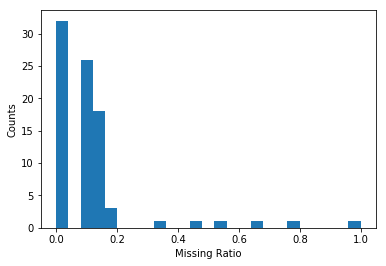

In [11]:
plt.hist(missing_p, bins = 25)
plt.xlabel('Missing Ratio')
plt.ylabel('Counts')
plt.show()

In [12]:
print('There are {} columns with more than 30% of missing data. These columns are outliers.'.format((missing_p > 0.3).sum()))

There are 6 columns with more than 30% of missing data. These columns are outliers.


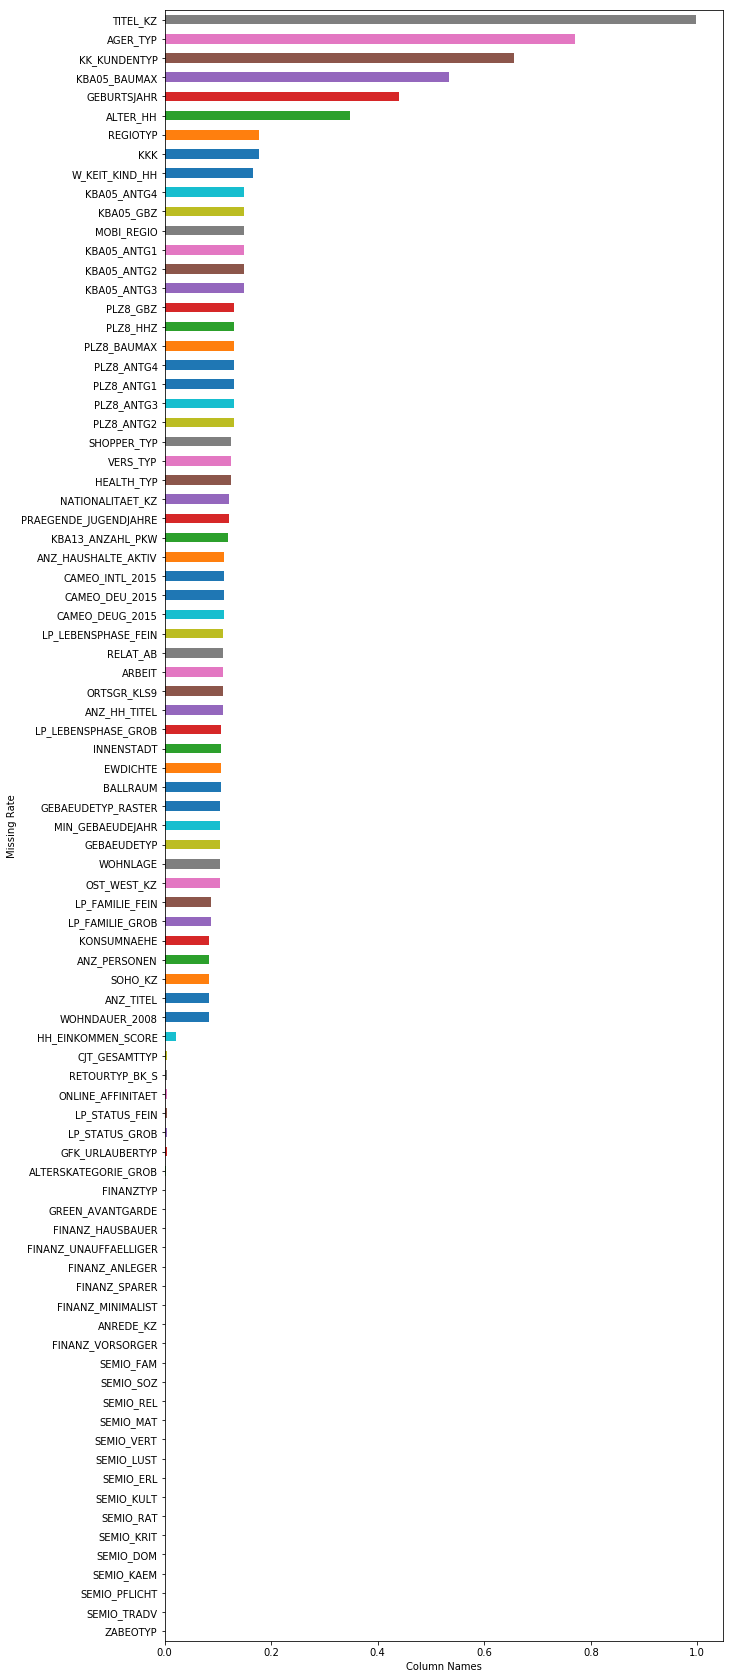

In [13]:
# Investigate patterns in the amount of missing data in each column.

missing_p.sort_values(inplace=False).plot.barh(figsize=(10, 30))
plt.xlabel('Column Names')
plt.ylabel('Missing Rate')
plt.show()

In [14]:
outlier_col = list(missing_p[missing_p > 0.3].index)
print(outlier_col)

['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']


In [15]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

# Drop 6 outliers 
azdias.drop(list(outlier_col),axis=1,inplace=True)
azdias.shape

(891221, 79)

In [16]:
feat_info_with_missing = feat_info
# feat_info_with_missing= pd.concat([feat_info_with_missing,
#                                    pd.DataFrame(missing_data,columns=['missing_count'])['missing_count'],
#                                    pd.DataFrame(missing_p,columns=['missing_p'])['missing_p']], axis=1, join='outer')
# pd.DataFrame(missing_data,columns=['attribute','missing_count'])
missing_table = pd.concat([pd.DataFrame(missing_data,columns=['missing_count']),
                           pd.DataFrame(missing_p,columns=['missing_p'])], axis=1)
missing_table.name = 'attribute'
missing_table.reset_index(inplace=True)
feat_info_with_missing = pd.concat([feat_info_with_missing,missing_table], axis=1)

In [17]:
feat_info_with_missing = feat_info
# feat_info_with_missing= pd.concat([feat_info_with_missing,
#                                    pd.DataFrame(missing_data,columns=['missing_count'])['missing_count'],
#                                    pd.DataFrame(missing_p,columns=['missing_p'])['missing_p']], axis=1, join='outer')
# pd.DataFrame(missing_data,columns=['attribute','missing_count'])
missing_table = pd.concat([pd.DataFrame(missing_data,columns=['missing_count']),
                           pd.DataFrame(missing_p,columns=['missing_p'])], axis=1)
missing_table.name = 'attribute'
missing_table.reset_index(inplace=True)
feat_info_with_missing = pd.concat([feat_info_with_missing,missing_table], axis=1)

In [18]:
feat_info_with_missing.sort_values(by='missing_p',ascending=False, inplace=False)

,attribute,information_level,type,missing_or_unknown,index,missing_count,missing_p
40,TITEL_KZ,person,categorical,"[-1, 0]",TITEL_KZ,889061,0.997576
0,AGER_TYP,person,categorical,"[-1, 0]",AGER_TYP,685843,0.769554
47,KK_KUNDENTYP,household,categorical,[-1],KK_KUNDENTYP,584612,0.655967
64,KBA05_BAUMAX,microcell_rr3,mixed,"[-1, 0]",KBA05_BAUMAX,476524,0.534687
11,GEBURTSJAHR,person,numeric,[0],GEBURTSJAHR,392318,0.440203
43,ALTER_HH,household,interval,[0],ALTER_HH,310267,0.348137
70,KKK,region_rr1,ordinal,"[-1, 0]",KKK,158064,0.177357
73,REGIOTYP,region_rr1,ordinal,"[-1, 0]",REGIOTYP,158064,0.177357
48,W_KEIT_KIND_HH,household,ordinal,"[-1, 0]",W_KEIT_KIND_HH,147988,0.166051
60,KBA05_ANTG1,microcell_rr3,ordinal,[-1],KBA05_ANTG1,133324,0.149597


#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

There were 6 columns that had more than 30% of data missing. These were considered as outliers and were dropped. Most of columns had missing data less than 20%. When checking the feature info, there wasn't any pattern observed related to missing data ratio. 

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [19]:
# How much data is missing in each row of the dataset?
missing_data_row = azdias.isnull().sum(axis=1)
missing_p_row = missing_data_row/azdias.shape[1]

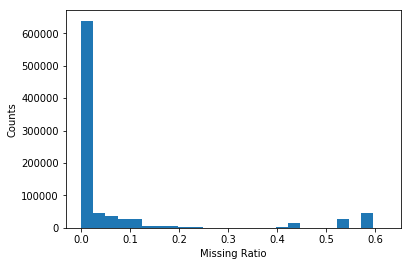

In [20]:
# data missing ratio plot for rows
plt.hist(missing_p_row, bins = 25)
plt.xlabel('Missing Ratio')
plt.ylabel('Counts')
plt.show()

In [21]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

In [22]:
more_missing_data = azdias[missing_p_row>0.1].reset_index(drop=True)
more_missing_data.shape

(144112, 79)

In [23]:
few_missing_data = azdias[missing_p_row<=0.1].reset_index(drop=True)
few_missing_data.shape

(747109, 79)

In [24]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

#set seed 
np.random.seed(40)
sample_col_idx = np.random.randint(azdias.shape[1], size=5)
sample_col_idx

array([70,  7, 37, 56, 50])

In [25]:
sample_few_missing = few_missing_data.iloc[:,sample_col_idx]
sample_more_missing = more_missing_data.iloc[:,sample_col_idx]

In [ ]:
# for idx in sample_col_idx:
#     fig = plt.figure(figsize=(20, 5))
#     fig.suptitle(azdias.columns[idx])
#     ax1 = fig.add_subplot(121)
#     ax1.title.set_text('More_missing_data')
#     sns.countplot(more_missing_data[azdias.columns[idx]])
#     ax2 = fig.add_subplot(122)
#     ax2.title.set_text('few_missing_data')
#     sns.countplot(few_missing_data[azdias.columns[idx]])
#     plt.show();

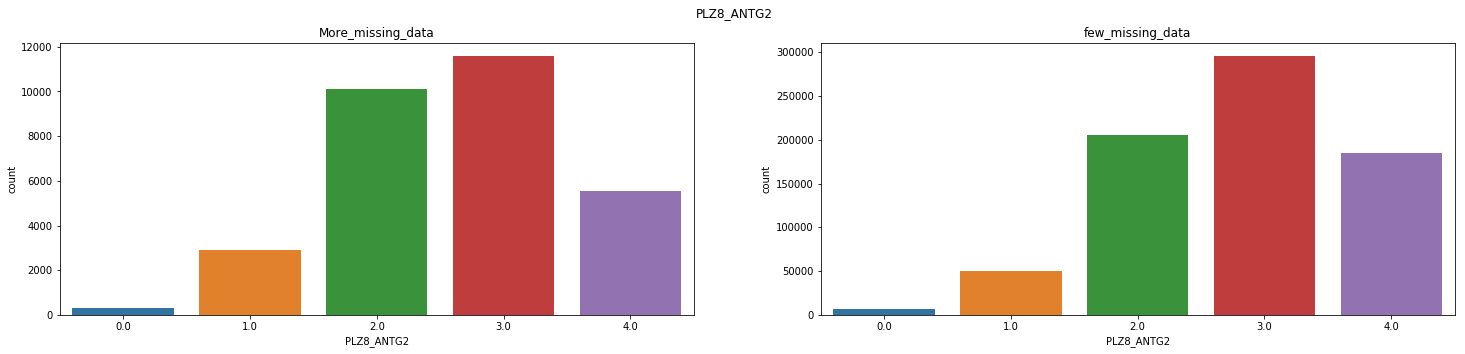

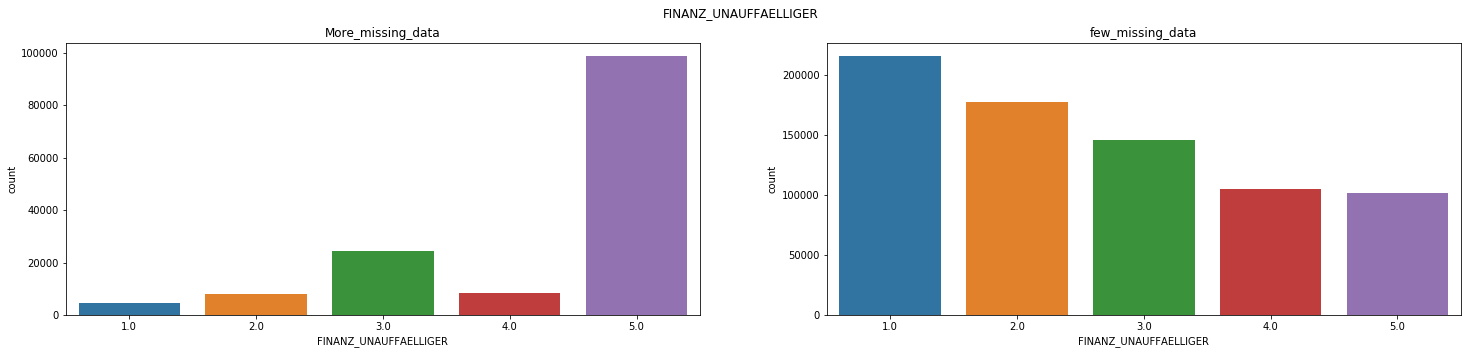

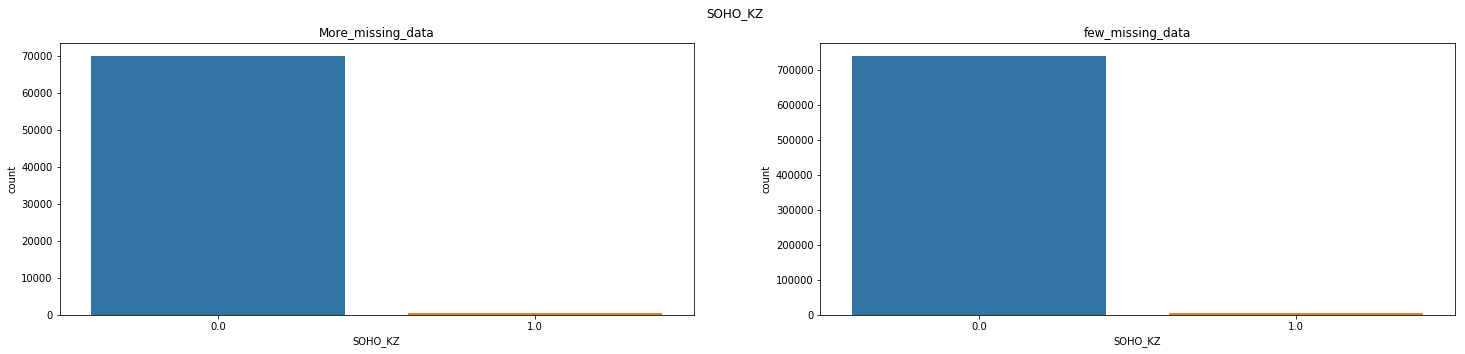

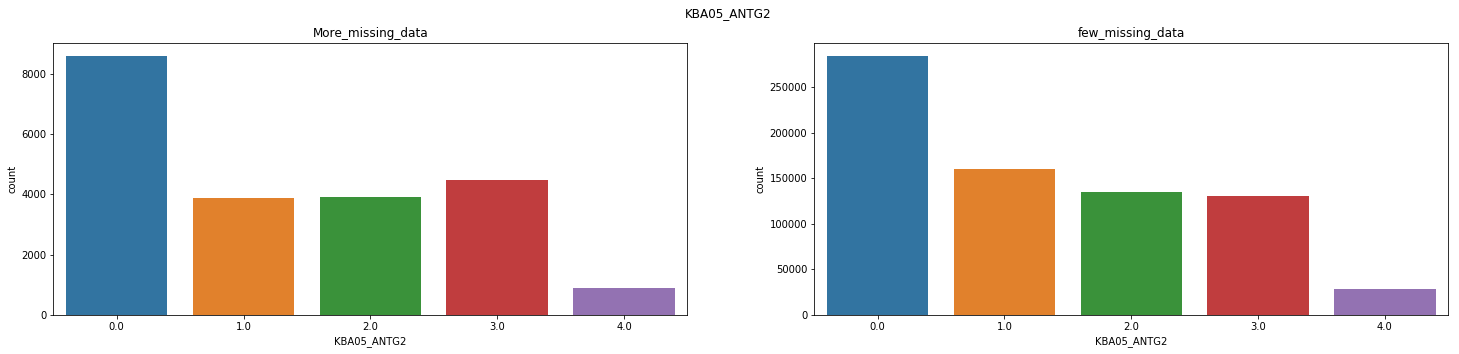

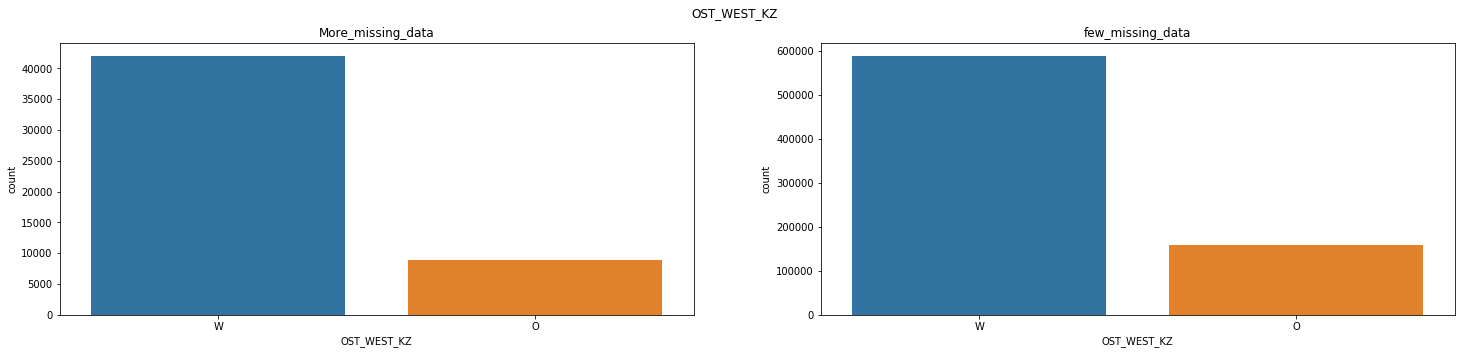

In [26]:
for idx in sample_col_idx:
    
    fig = plt.figure(figsize=(25, 5))
    fig.suptitle(azdias.columns[idx])
    
    ax1 = fig.add_subplot(121)
    ax1.title.set_text('More_missing_data')
    sns.countplot(more_missing_data[azdias.columns[idx]])
#     ax1.set_ylim([0, 250000])
    
    ax2 = fig.add_subplot(122)
    ax2.title.set_text('few_missing_data')
    sns.countplot(few_missing_data[azdias.columns[idx]])
#     ax2.set_ylim([0, 250000])
    
#     ax3 = fig.add_subplot(143)
#     p_more = lambda i: len(i) / float(len(more_missing_data[azdias.columns[idx]])) * 100
#     sns.barplot(x=more_missing_data[azdias.columns[idx]], y=more_missing_data[azdias.columns[idx]],  estimator=p_more)
#     ax3.title.set_text('More_missing_data (normalized)')
# #     (pd.Series(more_missing_data[azdias.columns[idx]]).value_counts(normalize=True, sort=False)*100).plot.bar()
#     ax3.set(ylabel="Percent")
#     ax3.set_ylim([0, 50])
    
#     ax4 = fig.add_subplot(144)
#     p_few = lambda i: len(i) / float(len(few_missing_data[azdias.columns[idx]])) * 100
#     sns.barplot(x=few_missing_data[azdias.columns[idx]], y=few_missing_data[azdias.columns[idx]],  estimator=p_few)
#     ax4.title.set_text('few_missing_data (normalized)')
# #     (pd.Series(few_missing_data[azdias.columns[idx]]).value_counts(normalize=True, sort=False)*100).plot.bar()
#     ax4.set(ylabel="Percent")
#     ax4.set_ylim([0, 50])
    
    plt.show();      

#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

Data is defined as a "few missing" when it has less than or equal to 10% of missing features. If the data has more than 10% of missing feature, it was defined as "more missing". 

Five features were manually compared. Out of all five compared, the distrubution of few missing features and more missing features for four of them look similar. They are 'PLZ8_ANTG2', 'SOHO_KZ', 'KBA05_ANTG2', and 'OST_WEST_KZ'. The patterns generally look similar when comparting between few missing features and more missing features. This shows the data is qualitatively similar between the rows. 

However, for 'FINANZ_UNAUFFAELLIGER', the distribution looked significantly different. More missing data for 'FINANZ_UNAUFFAELLIGER' was left-skewed, where few missing data was right-skewed. This shows the data for more missing feature is qualitativey different from data with few missing features.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [27]:
# How many features are there of each data type?
    
unique_types = pd.concat([pd.DataFrame(feat_info.type.unique(),columns=['unique_type']),
                          pd.DataFrame(np.zeros(len(feat_info.type.unique())),columns=['type_in_removed_col'])],axis=1)


for removed_col in outlier_col:
    removed_type = feat_info[feat_info['attribute']==removed_col].iloc[0]['type']
    for n in np.arange(unique_types.shape[0]):
        if unique_types['unique_type'][n]==removed_type:
            unique_types['type_in_removed_col'][n] = unique_types['type_in_removed_col'][n]+1

unique_types

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


,unique_type,type_in_removed_col
0,categorical,3.0
1,ordinal,0.0
2,numeric,1.0
3,mixed,1.0
4,interval,1.0


In [28]:
for unique_type in feat_info.type.unique():
    u_remove = int(unique_types['type_in_removed_col'][unique_types.index[unique_types['unique_type']==unique_type].tolist()[0]])
    u_type = sum(feat_info['type']==unique_type) - u_remove
    print('{} type count: '.format(unique_type), u_type)

categorical type count:  18
ordinal type count:  49
numeric type count:  6
mixed type count:  6
interval type count:  0


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [29]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

# Drop removed columns 
for removed_col in outlier_col:
    feat_info=feat_info[feat_info['attribute']!=removed_col]
feat_info.shape

(79, 4)

In [30]:
feat_categorical = feat_info[feat_info.type == 'categorical']['attribute']

In [31]:
binary_categories = []
multi_categories = []
for attb in feat_categorical:
    if few_missing_data[attb].nunique() > 2:
        multi_categories.append(attb)
    else:
        binary_categories.append(attb)

In [32]:
# There is one binary cateogry with non-numerical value 
few_missing_data['OST_WEST_KZ'].replace(['W', 'O'], [1, 0], inplace=True)

In [36]:
multi_categories

['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [37]:
# Re-encode categorical variable(s) to be kept in the analysis.
# For convenience, the multi-level variables will be dropped 
few_missing_data.drop(multi_categories, axis = 1, inplace=True)

# few_missing_data = pd.get_dummies(few_missing_data, columns=multi_categories)

In [38]:
few_missing_data.shape

(747109, 66)

#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

A binary category feature, 'OST_WEST_KZ', was encoded with 1 and 0 because it only had non-numerical values. Multi-level categories were dropped for convenience.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [39]:
feat_mix = feat_info[feat_info.type == 'mixed']['attribute']
feat_mix

15      LP_LEBENSPHASE_FEIN
16      LP_LEBENSPHASE_GROB
22    PRAEGENDE_JUGENDJAHRE
56                 WOHNLAGE
59          CAMEO_INTL_2015
79              PLZ8_BAUMAX
Name: attribute, dtype: object

In [40]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

# Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
# - -1: unknown
# -  0: unknown
# -  1: 40s - war years (Mainstream, E+W)
# -  2: 40s - reconstruction years (Avantgarde, E+W)
# -  3: 50s - economic miracle (Mainstream, E+W)
# -  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
# -  5: 60s - economic miracle (Mainstream, E+W)
# -  6: 60s - generation 68 / student protestors (Avantgarde, W)
# -  7: 60s - opponents to the building of the Wall (Avantgarde, E)
# -  8: 70s - family orientation (Mainstream, E+W)
# -  9: 70s - peace movement (Avantgarde, E+W)
# - 10: 80s - Generation Golf (Mainstream, W)
# - 11: 80s - ecological awareness (Avantgarde, W)
# - 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
# - 13: 80s - Swords into ploughshares (Avantgarde, E)
# - 14: 90s - digital media kids (Mainstream, E+W)
# - 15: 90s - ecological awareness (Avantgarde, E+W)

# Movement 

mov = []
movement_n = 0 
for n in few_missing_data['PRAEGENDE_JUGENDJAHRE']:
    if n == np.nan:
        movement_n = np.nan
    elif n in [1,3,5,8,10,12,14]:
        movement_n = 1
    else:
        movement_n = 0
    mov.append(movement_n)
# 0 = avantgarde
# 1 = mainstream

few_missing_data['PRAEGENDE_JUGENDJAHRE_MOVEMENT']=mov


# Generation 
gen = []
gen_n = 0 
for n in few_missing_data['PRAEGENDE_JUGENDJAHRE']:
    if n in [1, 2]:
        gen_n = 0
    elif n in [3, 4]:
        gen_n = 1
    elif n in [5, 6, 7]:
        gen_n = 2
    elif n in [8, 9]:
        gen_n = 3
    elif n in [10, 11, 12, 13]:
        gen_n = 4
    elif n in [10, 11, 12, 13]:
        gen_n = 5
    else:
        gen_n = np.nan
    gen.append(gen_n)

# 0 = 40s
# 1 = 50s
# 2 = 60s
# 3 = 70s
# 4 = 80s
# 5 = 90s

few_missing_data['PRAEGENDE_JUGENDJAHRE_GENERATION']=gen


In [42]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
# German CAMEO: Wealth / Life Stage Typology, mapped to international code
# - -1: unknown
# - 11: Wealthy Households - Pre-Family Couples & Singles
# - 12: Wealthy Households - Young Couples With Children
# - 13: Wealthy Households - Families With School Age Children
# - 14: Wealthy Households - Older Families &  Mature Couples
# - 15: Wealthy Households - Elders In Retirement
# - 21: Prosperous Households - Pre-Family Couples & Singles
# - 22: Prosperous Households - Young Couples With Children
# - 23: Prosperous Households - Families With School Age Children
# - 24: Prosperous Households - Older Families & Mature Couples
# - 25: Prosperous Households - Elders In Retirement
# - 31: Comfortable Households - Pre-Family Couples & Singles
# - 32: Comfortable Households - Young Couples With Children
# - 33: Comfortable Households - Families With School Age Children
# - 34: Comfortable Households - Older Families & Mature Couples
# - 35: Comfortable Households - Elders In Retirement
# - 41: Less Affluent Households - Pre-Family Couples & Singles
# - 42: Less Affluent Households - Young Couples With Children
# - 43: Less Affluent Households - Families With School Age Children
# - 44: Less Affluent Households - Older Families & Mature Couples
# - 45: Less Affluent Households - Elders In Retirement
# - 51: Poorer Households - Pre-Family Couples & Singles
# - 52: Poorer Households - Young Couples With Children
# - 53: Poorer Households - Families With School Age Children
# - 54: Poorer Households - Older Families & Mature Couples
# - 55: Poorer Households - Elders In Retirement
# - XX: unknown
    
# wealth 
wealth = []
wealth_n = 0 

for n in few_missing_data['CAMEO_INTL_2015']:
    if str(n).isnumeric():
        if int(n) > 0:
            wealth_n = int(str(n)[0]) # 1st digit
        else:
            wealth_n = np.nan
    else:
        wealth_n = np.nan
    wealth.append(wealth_n)
# 1 = wealthy
# 2 = prosperous
# 3 = comfortable
# 4 = less affluent
# 5 = poorer 
few_missing_data['CAMEO_INTL_2015_WEALTH']=wealth



# life stage
life = []
life_n = 0 

for n in few_missing_data['CAMEO_INTL_2015']:
    if str(n).isnumeric():
        if int(n) > 0:
            life_n = int(str(n)[1:]) # 2nd digit
        else:
            life_n = np.nan
    else:
        life_n = np.nan
    life.append(life_n)
# 1 = Pre-Family Couples & Singles
# 2 = Young Couples With Children
# 3 = Families With School Age Children
# 4 = Older Families &  Mature Couples
# 5 = Elders In Retirement
few_missing_data['CAMEO_INTL_2015_LIFESTAGE']=life

In [43]:
# Drop original 
few_missing_data.drop(['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015'], axis = 1, inplace=True)

In [44]:
# Drop other Mixed-types 
few_missing_data.drop(['LP_LEBENSPHASE_FEIN',
            'LP_LEBENSPHASE_GROB',
            'WOHNLAGE',
            'PLZ8_BAUMAX'], axis = 1, inplace=True)

#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

'PRAEGENDE_JUGENDJAHRE' feature was separated into two different features, 'PRAEGENDE_JUGENDJAHRE_MOVEMENT' and 'PRAEGENDE_JUGENDJAHRE_GENERATION'. 'PRAEGENDE_JUGENDJAHRE_MOVEMENT' feature is a binary feature where 0 is the avantgarde and 1 is the mainstream. 'PRAEGENDE_JUGENDJAHRE_GENERATION' is a multi-level feature where 0 is 40s, 1 is 50s, 2 is 60s, 3 is 70s, 4 is 80s, and 5 is 90s.

'CAMEO_INTL_2015' feature was separated into two different features, 'CAMEO_INTL_2015_WEALTH' and 'CAMEO_INTL_2015_LIFESTAGE'. 'CAMEO_INTL_2015_WEALTH' feature is a multi-level feature where 1 is wealthy, 2 is prosperous, 3 is comfortable, 4 is less affluent, and 5 is poorer. 'CAMEO_INTL_2015_LIFESTAGE' is a multi-level feature where 1 is Pre-Family Couples & Singles, 2 is Young Couples With Children, 3 is Families With School Age Children, 4 is Older Families &  Mature Couples, and 5 is Elders In Retirement.

Rest of Mixed-type features were dropped as the instruction said they do not need much attention. 

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [45]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

few_missing_data.isnull().sum().sort_values()
# few_missing_data.isnull().sum().hist(bins=50)

WOHNDAUER_2008                           0
MIN_GEBAEUDEJAHR                         0
ONLINE_AFFINITAET                        0
HH_EINKOMMEN_SCORE                       0
ANZ_TITEL                                0
ANZ_PERSONEN                             0
SOHO_KZ                                  0
SEMIO_TRADV                              0
SEMIO_PFLICHT                            0
SEMIO_KAEM                               0
SEMIO_DOM                                0
SEMIO_KRIT                               0
SEMIO_RAT                                0
OST_WEST_KZ                              0
SEMIO_ERL                                0
SEMIO_LUST                               0
SEMIO_KULT                               0
SEMIO_MAT                                0
ANREDE_KZ                                0
FINANZ_MINIMALIST                        0
FINANZ_SPARER                            0
FINANZ_VORSORGER                         0
SEMIO_VERT                               0
FINANZ_UNAU

In [46]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.



### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [53]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Load in the feature summary file.
    feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv", delimiter=";")
    
    # str to list
    feat_info['missing_or_unknown'] = feat_info['missing_or_unknown'].apply(lambda x: x[1:-1].split(','))
    
    # Identify missing or unknown data values and convert them to NaNs.

    for n in np.arange(feat_info.shape[0]):
        attb = feat_info['attribute'][n]
        nanvals = feat_info['missing_or_unknown'][n]
        if nanvals != ['']:
            for val in nanvals:
                try:
                    val = int(val)
                except:
                    val = val
                df.loc[df[attb] == val,attb] = np.nan
    
    # Perform an assessment of how much missing data there is in each column of the dataset.
    missing_data = df.isnull().sum()
    missing_p = df.isnull().sum() / df.shape[0]
    
    outlier_col = list(missing_p[missing_p > 0.3].index)
    # Drop 6 outliers 
    df.drop(list(outlier_col),axis=1,inplace=True)
    
    feat_info_with_missing = feat_info
    missing_table = pd.concat([pd.DataFrame(missing_data,columns=['missing_count']),
                               pd.DataFrame(missing_p,columns=['missing_p'])], axis=1)
    missing_table.name = 'attribute'
    missing_table.reset_index(inplace=True)
    feat_info_with_missing = pd.concat([feat_info_with_missing,missing_table], axis=1)
    
    # How much data is missing in each row of the dataset?
    missing_data_row = df.isnull().sum(axis=1)
    missing_p_row = missing_data_row/df.shape[1]
    more_missing_data = df[missing_p_row>0.1].reset_index(drop=True)
    few_missing_data = df[missing_p_row<=0.1].reset_index(drop=True)

    
    # How many features are there of each data type?
    unique_types = pd.concat([pd.DataFrame(feat_info.type.unique(),columns=['unique_type']),
                          pd.DataFrame(np.zeros(len(feat_info.type.unique())),columns=['type_in_removed_col'])],axis=1)

    for removed_col in outlier_col:
        removed_type = feat_info[feat_info['attribute']==removed_col].iloc[0]['type']
        for n in np.arange(unique_types.shape[0]):
            if unique_types['unique_type'][n]==removed_type:
                unique_types['type_in_removed_col'][n] = unique_types['type_in_removed_col'][n]+1

    for unique_type in feat_info.type.unique():
        u_remove = int(unique_types['type_in_removed_col'][unique_types.index[unique_types['unique_type']==unique_type].tolist()[0]])
        u_type = sum(feat_info['type']==unique_type) - u_remove

    # Drop removed columns 
    for removed_col in outlier_col:
        feat_info=feat_info[feat_info['attribute']!=removed_col]
    
    
    # Assess categorical variables: which are binary, which are multi-level, and
    # which one needs to be re-encoded?
    feat_categorical = feat_info[feat_info.type == 'categorical']['attribute']
    binary_categories = []
    multi_categories = []
    for attb in feat_categorical:
        if few_missing_data[attb].nunique() > 2:
            multi_categories.append(attb)
        else:
            binary_categories.append(attb)
    few_missing_data['OST_WEST_KZ'].replace(['W', 'O'], [1, 0], inplace=True)
    few_missing_data.drop(multi_categories, axis = 1, inplace=True)
    
    
    #clean Mixed type 
    feat_mix = feat_info[feat_info.type == 'mixed']['attribute']

    # Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
    # Movement 

    mov = []
    movement_n = 0 
    for n in few_missing_data['PRAEGENDE_JUGENDJAHRE']:
        if n == np.nan:
            movement_n = np.nan
        elif n in [1,3,5,8,10,12,14]:
            movement_n = 1
        else:
            movement_n = 0
        mov.append(movement_n)
    # 0 = avantgarde
    # 1 = mainstream

    few_missing_data['PRAEGENDE_JUGENDJAHRE_MOVEMENT']=mov

    # Generation 
    gen = []
    gen_n = 0 
    for n in few_missing_data['PRAEGENDE_JUGENDJAHRE']:
        if n in [1, 2]:
            gen_n = 0
        elif n in [3, 4]:
            gen_n = 1
        elif n in [5, 6, 7]:
            gen_n = 2
        elif n in [8, 9]:
            gen_n = 3
        elif n in [10, 11, 12, 13]:
            gen_n = 4
        elif n in [10, 11, 12, 13]:
            gen_n = 5
        else:
            gen_n = np.nan
        gen.append(gen_n)

    # 0 = 40s
    # 1 = 50s
    # 2 = 60s
    # 3 = 70s
    # 4 = 80s
    # 5 = 90s

    few_missing_data['PRAEGENDE_JUGENDJAHRE_GENERATION']=gen
    
    # Investigate "CAMEO_INTL_2015" and engineer two new variables.
    # wealth 
    wealth = []
    wealth_n = 0 

    for n in few_missing_data['CAMEO_INTL_2015']:
        if str(n).isnumeric():
            if int(n) > 0:
                wealth_n = int(str(n)[0]) # 1st digit
            else:
                wealth_n = np.nan
        else:
            wealth_n = np.nan
        wealth.append(wealth_n)
    # 1 = wealthy
    # 2 = prosperous
    # 3 = comfortable
    # 4 = less affluent
    # 5 = poorer 
    few_missing_data['CAMEO_INTL_2015_WEALTH']=wealth

    # life stage
    life = []
    life_n = 0 

    for n in few_missing_data['CAMEO_INTL_2015']:
        if str(n).isnumeric():
            if int(n) > 0:
                life_n = int(str(n)[1:]) # 2nd digit
            else:
                life_n = np.nan
        else:
            life_n = np.nan
        life.append(life_n)
    # 1 = Pre-Family Couples & Singles
    # 2 = Young Couples With Children
    # 3 = Families With School Age Children
    # 4 = Older Families &  Mature Couples
    # 5 = Elders In Retirement
    few_missing_data['CAMEO_INTL_2015_LIFESTAGE']=life
    
    # Drop original 
    few_missing_data.drop(['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015'], axis = 1, inplace=True)
    
    # Drop other Mixed-types 
    few_missing_data.drop(['LP_LEBENSPHASE_FEIN',
                'LP_LEBENSPHASE_GROB',
                'WOHNLAGE',
                'PLZ8_BAUMAX'], axis = 1, inplace=True)
    
    
    
    # Return the cleaned dataframe.
    
    return few_missing_data

In [54]:
# Test function 
azdias_test = pd.read_csv("Udacity_AZDIAS_Subset.csv", delimiter=";")
cleaned_test = clean_data(azdias_test)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [55]:
cleaned_test.isnull().sum().sort_values()

WOHNDAUER_2008                           0
MIN_GEBAEUDEJAHR                         0
ONLINE_AFFINITAET                        0
HH_EINKOMMEN_SCORE                       0
ANZ_TITEL                                0
ANZ_PERSONEN                             0
SOHO_KZ                                  0
SEMIO_TRADV                              0
SEMIO_PFLICHT                            0
SEMIO_KAEM                               0
SEMIO_DOM                                0
SEMIO_KRIT                               0
SEMIO_RAT                                0
OST_WEST_KZ                              0
SEMIO_ERL                                0
SEMIO_LUST                               0
SEMIO_KULT                               0
SEMIO_MAT                                0
ANREDE_KZ                                0
FINANZ_MINIMALIST                        0
FINANZ_SPARER                            0
FINANZ_VORSORGER                         0
SEMIO_VERT                               0
FINANZ_UNAU

In [56]:
cleaned_test.shape

(747109, 64)

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [57]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

# drop all rows with missing data
cleaned_test = cleaned_test.dropna()
cleaned_test.isnull().sum().sort_values()

ALTERSKATEGORIE_GROB                0
KONSUMNAEHE                         0
MIN_GEBAEUDEJAHR                    0
OST_WEST_KZ                         0
KBA05_ANTG1                         0
KBA05_ANTG2                         0
KBA05_ANTG3                         0
KBA05_ANTG4                         0
KBA05_GBZ                           0
BALLRAUM                            0
EWDICHTE                            0
INNENSTADT                          0
GEBAEUDETYP_RASTER                  0
KKK                                 0
ANZ_HH_TITEL                        0
MOBI_REGIO                          0
REGIOTYP                            0
KBA13_ANZAHL_PKW                    0
PLZ8_ANTG1                          0
PLZ8_ANTG2                          0
PLZ8_ANTG3                          0
PLZ8_ANTG4                          0
PLZ8_HHZ                            0
PLZ8_GBZ                            0
ARBEIT                              0
ORTSGR_KLS9                         0
RELAT_AB    

In [58]:
cleaned_test.shape

(444999, 64)

In [59]:
# Apply feature scaling to the general population demographics data.

ss = StandardScaler()
scaler_data = ss.fit_transform(cleaned_test)

In [60]:
pd.DataFrame(scaler_data).describe()

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
count,4.449990e+05,4.449990e+05,4.449990e+05,4.449990e+05,4.449990e+05,4.449990e+05,4.449990e+05,4.449990e+05,4.449990e+05,4.449990e+05,...,4.449990e+05,4.449990e+05,4.449990e+05,4.449990e+05,4.449990e+05,4.449990e+05,4.449990e+05,4.449990e+05,4.449990e+05,4.449990e+05
mean,1.478571e-16,-2.847367e-17,8.529725e-17,1.217346e-16,-2.199095e-16,-1.837835e-17,-4.585805e-17,-5.208529e-17,1.823464e-17,-1.370313e-16,...,-1.002746e-17,-5.449636e-17,6.802065e-17,-2.117741e-16,2.041258e-16,-5.880752e-17,-1.823464e-17,1.181579e-18,1.545634e-16,-1.455897e-16
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,...,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-2.862549e+00,-1.004200e+00,-2.162334e+00,-9.166847e-01,-2.838629e+00,-1.012442e+00,-9.303752e-01,-1.510692e+00,-5.821499e-01,-1.578486e+00,...,-9.636772e-01,-2.708068e+00,-2.145200e+00,-2.203396e+00,-1.895650e+00,-1.549233e+00,-1.717771e+00,-2.267332e+00,-1.559103e+00,-1.307480e+00
25%,-2.512273e-01,-1.004200e+00,-4.448582e-01,-9.166847e-01,-5.620713e-02,-1.012442e+00,-9.303752e-01,-7.790984e-01,-5.821499e-01,-2.412601e-01,...,-9.636772e-01,-6.291965e-01,-3.368668e-01,-1.895735e-01,-5.855916e-01,-8.118011e-01,-1.717771e+00,-5.449877e-01,-8.752989e-01,-1.307480e+00
50%,-2.512273e-01,9.958177e-01,4.138798e-01,1.878083e-02,-5.620713e-02,-1.837320e-01,5.086589e-02,-4.750440e-02,-5.821499e-01,-2.412601e-01,...,4.198547e-01,-6.291965e-01,-3.368668e-01,-1.895735e-01,-1.489054e-01,-7.436971e-02,5.821499e-01,3.161844e-01,4.923093e-01,2.741184e-02
75%,1.054433e+00,9.958177e-01,1.272618e+00,9.542464e-01,8.712668e-01,6.449782e-01,1.032107e+00,6.840896e-01,1.717771e+00,1.095965e+00,...,4.198547e-01,4.102394e-01,5.672998e-01,8.173376e-01,7.244669e-01,6.630617e-01,5.821499e-01,1.177356e+00,1.176113e+00,6.948577e-01
max,1.054433e+00,9.958177e-01,1.272618e+00,2.825177e+00,8.712668e-01,2.302398e+00,2.994589e+00,1.415684e+00,1.717771e+00,1.095965e+00,...,1.803387e+00,1.449675e+00,1.471466e+00,1.824249e+00,1.597839e+00,1.400493e+00,5.821499e-01,1.177356e+00,1.176113e+00,1.362304e+00


### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

First, all missing values were dropped before scalinFor the scaling function, StandardScaler was used to scale each feature. This normalize each feature to have mean of 0 and standard deviation of 1. 

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [61]:
# Apply PCA to the data.

pca = PCA()
pca_data = pca.fit_transform(scaler_data)

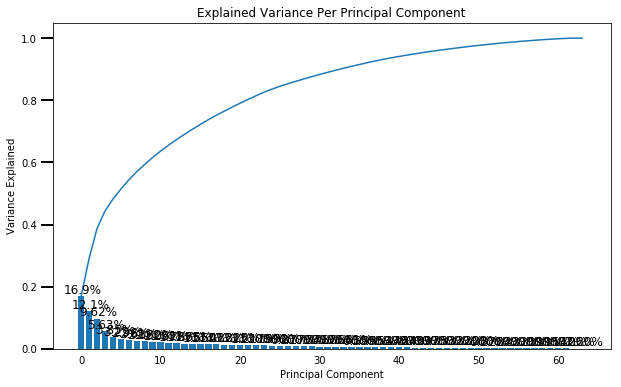

In [62]:
# Investigate the variance accounted for by each principal component.


# The following function is from the helper_functions.py (Class material)

def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained")
    plt.title('Explained Variance Per Principal Component')
    
scree_plot(pca)


In [65]:
print('Percent of variance explained by the first princimal component', round(pca.explained_variance_ratio_[0]*100,2),'%')
print('Percent of variance explained by the first 5 princimal component', 
      round(sum(pca.explained_variance_ratio_[:5]*100),2),'%.')
print('Percent of variance explained by the first 10 princimal component', 
      round(sum(pca.explained_variance_ratio_[:10]*100),2),'%.')
print('Percent of variance explained by the first 20 princimal component', 
      round(sum(pca.explained_variance_ratio_[:20]*100),2),'%.')
print('Percent of variance explained by the first 30 princimal component', 
      round(sum(pca.explained_variance_ratio_[:30]*100),2),'%.')
print('Percent of variance explained by the first 40 princimal component', 
      round(sum(pca.explained_variance_ratio_[:40]*100),2),'%.')
print('Percent of variance explained by the first 50 princimal component', 
      round(sum(pca.explained_variance_ratio_[:50]*100),2),'%.')
print('Percent of variance explained by the first 60 princimal component', 
      round(sum(pca.explained_variance_ratio_[:60]*100),2),'%.')

Percent of variance explained by the first princimal component 16.9 %
Percent of variance explained by the first 5 princimal component 48.18 %.
Percent of variance explained by the first 10 princimal component 61.59 %.
Percent of variance explained by the first 20 princimal component 77.81 %.
Percent of variance explained by the first 30 princimal component 87.61 %.
Percent of variance explained by the first 40 princimal component 93.66 %.
Percent of variance explained by the first 50 princimal component 97.39 %.
Percent of variance explained by the first 60 princimal component 99.66 %.


In [66]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca_re = PCA(n_components=30)
pca_data_re = pca_re.fit_transform(scaler_data)

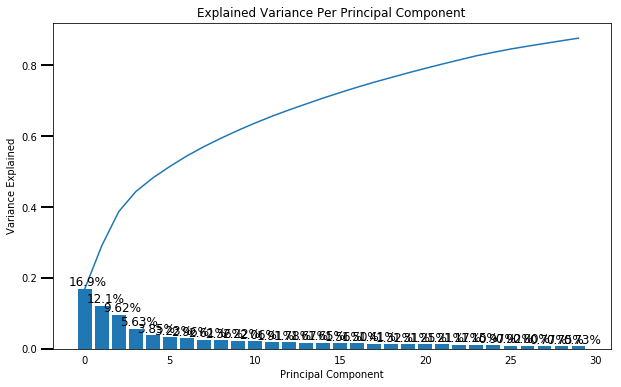

In [67]:
scree_plot(pca_re)

### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

As it is shown in the plot above, explained variance rapidly increase in the beginning, but it slows down as it have more principal components. Dimensions is decided to be reduced to 30 as it still has nearly 90% of variance explained about the data. 

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [68]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def pca_weights(df, pca,n_comp):
    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns=df.keys()).iloc[n_comp-1]
    components.sort_values(inplace=True);    
    fig = plt.figure(figsize=(10, 8));
#     ax1 = fig.add_subplot(121)
#     components.head(5).plot(kind='bar')
#     ax2 = fig.add_subplot(122)
#     components.tail(5).plot(kind='bar')
    pd.concat([components.head(5),components.tail(5)]).plot(kind='bar');
    plt.show();
    
    return components;

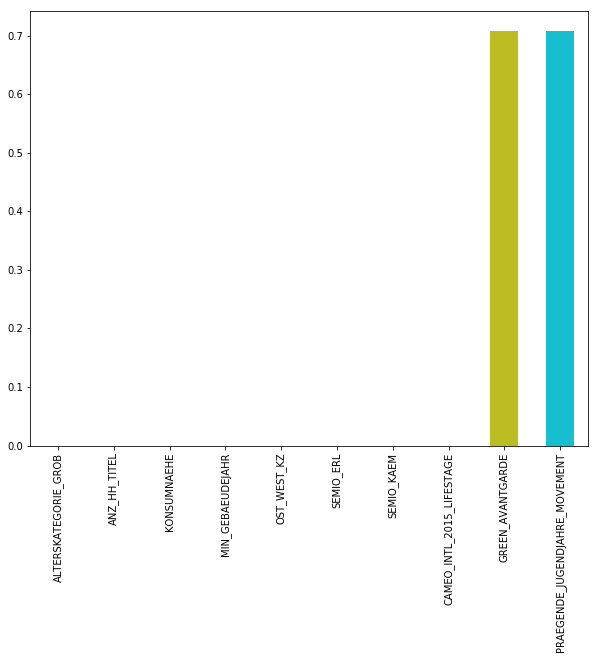

ALTERSKATEGORIE_GROB                0.0000
ANZ_HH_TITEL                        0.0000
KONSUMNAEHE                        -0.0000
MIN_GEBAEUDEJAHR                   -0.0000
OST_WEST_KZ                        -0.0000
KBA05_ANTG1                         0.0000
KBA05_ANTG2                         0.0000
KBA05_ANTG3                         0.0000
KBA05_ANTG4                         0.0000
KBA05_GBZ                          -0.0000
BALLRAUM                            0.0000
EWDICHTE                           -0.0000
INNENSTADT                          0.0000
GEBAEUDETYP_RASTER                  0.0000
ANZ_HAUSHALTE_AKTIV                -0.0000
KKK                                -0.0000
ONLINE_AFFINITAET                   0.0000
REGIOTYP                            0.0000
KBA13_ANZAHL_PKW                    0.0000
PLZ8_ANTG1                         -0.0000
PLZ8_ANTG2                          0.0000
PLZ8_ANTG3                         -0.0000
PLZ8_ANTG4                         -0.0000
PLZ8_HHZ   

In [166]:
# Check first components
p0 = pca_weights(cleaned_test, pca, 0)
print(p0)

In [167]:
print("10 most weighted feature in the first component:")
print(p0.head(5))
print(p0.tail(5))

10 most weighted feature in the third component:
ALTERSKATEGORIE_GROB    0.0
ANZ_HH_TITEL            0.0
KONSUMNAEHE            -0.0
MIN_GEBAEUDEJAHR       -0.0
OST_WEST_KZ            -0.0
Name: 63, dtype: float64
SEMIO_ERL                         0.0000
SEMIO_KAEM                        0.0000
CAMEO_INTL_2015_LIFESTAGE         0.0000
GREEN_AVANTGARDE                  0.7071
PRAEGENDE_JUGENDJAHRE_MOVEMENT    0.7071
Name: 63, dtype: float64


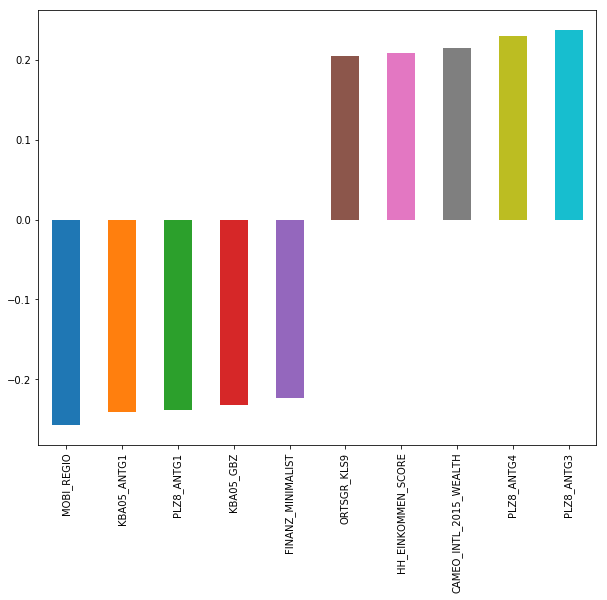

MOBI_REGIO                         -0.2577
KBA05_ANTG1                        -0.2411
PLZ8_ANTG1                         -0.2383
KBA05_GBZ                          -0.2326
FINANZ_MINIMALIST                  -0.2232
PLZ8_GBZ                           -0.1783
KONSUMNAEHE                        -0.1721
INNENSTADT                         -0.1706
BALLRAUM                           -0.1308
GEBAEUDETYP_RASTER                 -0.1208
GREEN_AVANTGARDE                   -0.1202
CAMEO_INTL_2015_LIFESTAGE          -0.1199
ONLINE_AFFINITAET                  -0.0936
ANZ_PERSONEN                       -0.0927
KBA13_ANZAHL_PKW                   -0.0832
ALTERSKATEGORIE_GROB               -0.0768
FINANZ_VORSORGER                   -0.0756
OST_WEST_KZ                        -0.0620
SEMIO_LUST                         -0.0464
MIN_GEBAEUDEJAHR                   -0.0415
WOHNDAUER_2008                     -0.0380
SEMIO_VERT                         -0.0373
SEMIO_ERL                          -0.0283
SOHO_KZ    

In [69]:
# Check second components

p1 = pca_weights(cleaned_test, pca, 1);
print(p1);

In [70]:
print("10 most weighted feature in the second component:")
print(p1.head(5))
print(p1.tail(5))

10 most weighted feature in the first component:
MOBI_REGIO          -0.2577
KBA05_ANTG1         -0.2411
PLZ8_ANTG1          -0.2383
KBA05_GBZ           -0.2326
FINANZ_MINIMALIST   -0.2232
Name: 0, dtype: float64
ORTSGR_KLS9               0.2043
HH_EINKOMMEN_SCORE        0.2081
CAMEO_INTL_2015_WEALTH    0.2152
PLZ8_ANTG4                0.2294
PLZ8_ANTG3                0.2372
Name: 0, dtype: float64


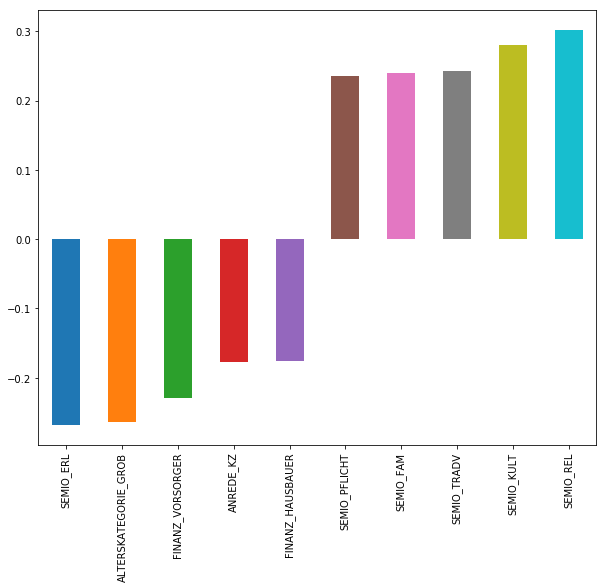

SEMIO_ERL                          -0.2682
ALTERSKATEGORIE_GROB               -0.2644
FINANZ_VORSORGER                   -0.2297
ANREDE_KZ                          -0.1767
FINANZ_HAUSBAUER                   -0.1762
SEMIO_LUST                         -0.1649
SEMIO_KAEM                         -0.1507
SEMIO_KRIT                         -0.1451
W_KEIT_KIND_HH                     -0.1285
RETOURTYP_BK_S                     -0.0829
SEMIO_DOM                          -0.0777
WOHNDAUER_2008                     -0.0403
CAMEO_INTL_2015_LIFESTAGE          -0.0348
VERS_TYP                           -0.0331
ARBEIT                             -0.0329
PLZ8_ANTG3                         -0.0329
ORTSGR_KLS9                        -0.0320
EWDICHTE                           -0.0314
PLZ8_ANTG4                         -0.0301
KBA05_ANTG4                        -0.0265
RELAT_AB                           -0.0261
ANZ_HAUSHALTE_AKTIV                -0.0245
CAMEO_INTL_2015_WEALTH             -0.0233
REGIOTYP   

In [123]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# Check third components

p2 = pca_weights(cleaned_test, pca, 2)
print(p2)


In [72]:
print("10 most weighted feature in the third component:")
print(p2.head(5))
print(p2.tail(5))

10 most weighted feature in the second component:
SEMIO_ERL              -0.2682
ALTERSKATEGORIE_GROB   -0.2644
FINANZ_VORSORGER       -0.2297
ANREDE_KZ              -0.1767
FINANZ_HAUSBAUER       -0.1762
Name: 1, dtype: float64
SEMIO_PFLICHT    0.2357
SEMIO_FAM        0.2393
SEMIO_TRADV      0.2421
SEMIO_KULT       0.2801
SEMIO_REL        0.3024
Name: 1, dtype: float64


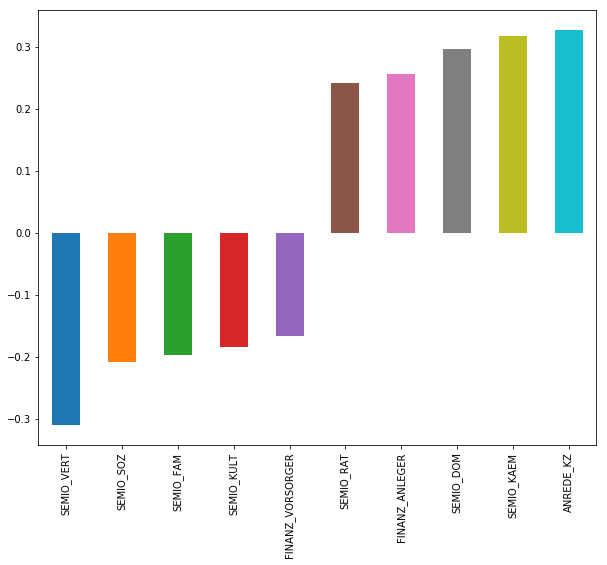

SEMIO_VERT                         -0.3103
SEMIO_SOZ                          -0.2077
SEMIO_FAM                          -0.1970
SEMIO_KULT                         -0.1833
FINANZ_VORSORGER                   -0.1660
ALTERSKATEGORIE_GROB               -0.1628
FINANZ_MINIMALIST                  -0.1612
W_KEIT_KIND_HH                     -0.1439
RETOURTYP_BK_S                     -0.1337
SEMIO_LUST                         -0.1235
EWDICHTE                           -0.0599
ORTSGR_KLS9                        -0.0583
PLZ8_ANTG3                         -0.0501
VERS_TYP                           -0.0493
PLZ8_ANTG4                         -0.0490
GREEN_AVANTGARDE                   -0.0478
SEMIO_REL                          -0.0371
ARBEIT                             -0.0369
RELAT_AB                           -0.0358
WOHNDAUER_2008                     -0.0347
PLZ8_ANTG2                         -0.0346
FINANZ_HAUSBAUER                   -0.0299
KBA05_ANTG4                        -0.0276
ANZ_HAUSHAL

In [73]:
# Map weights for the forth principal component to corresponding feature names
# and then print the linked values, sorted by weight.
#Check forth component 
p3 = pca_weights(cleaned_test, pca, 3)
print(p3)


In [74]:
print("10 most weighted feature in the third component:")
print(p3.head(5))
print(p3.tail(5))

10 most weighted feature in the third component:
SEMIO_VERT         -0.3103
SEMIO_SOZ          -0.2077
SEMIO_FAM          -0.1970
SEMIO_KULT         -0.1833
FINANZ_VORSORGER   -0.1660
Name: 2, dtype: float64
SEMIO_RAT         0.2422
FINANZ_ANLEGER    0.2566
SEMIO_DOM         0.2963
SEMIO_KAEM        0.3178
ANREDE_KZ         0.3269
Name: 2, dtype: float64


### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

10 most weighted features were analyzed in the first four principal components.Interestingly, the first principal component is heavily weighted on just two features, GREEN_AVANTGARDE(Membership in environmental sustainability as part of youth) and
PRAEGENDE_JUGENDJAHRE(Dominating movement of person's youth), which shows youth is playing significant role. It indicates being a member of Green Avantgarde forms a strong and clear cluster of the population as well as dominating movement of person's youth

The second principal component is heavily towards on the microcell features in both positive and negative values. Exmaples are: Movement patterns in RR1 region features, Number of buildings in the microcell, Number of 1-2 family houses in the microcell. However, micro cell was not the only feature weighed. Social status, Estimated household net income, or Financial typology were also observed in the second principal component. 

Compare to the second principal component, the third and the fprtj principal component's heavy weight was focused on Person-level features (i.e. Estimated age based on given name analysis, FINANZ_VORSORGER, ZABEOTYP_3.0, Personality typology, etc.)

Positive and negative values do not have as much information as it would be in other type of data. It's magnitude matters more.



## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [75]:
# creating a smaller dataset 
np.random.seed(40)
pca_data_re_subset = pca_data_re[np.random.choice(pca_data_re.shape[0], int(pca_data_re.shape[0]*0.10), replace=False)]


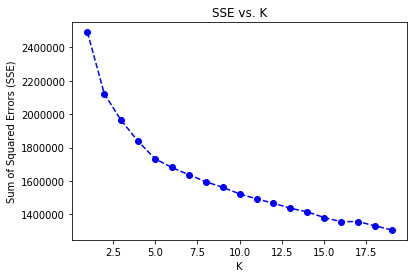

In [76]:
# Over a number of different cluster counts...
    # run k-means clustering on the data and...
    # compute the average within-cluster distances.
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
def get_kmeans_score(data, center):
    kmeans = KMeans(n_clusters=center)
    model = kmeans.fit(data)
    score = np.abs(model.score(data))
    return score

scores  = [] 
centers = list(range(1,20))


for n in centers:
    scores.append(get_kmeans_score(pca_data_re_subset, n))
    
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('Sum of Squared Errors (SSE)');
plt.title('SSE vs. K');

In [77]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans = KMeans(n_clusters = 5)
cluster_predict = kmeans.fit_predict(pca_data_re_subset)

In [78]:
# plt.figure(figsize=(16,12))
# plt.scatter(pca_data_re_subset[:,0], pca_data_re_subset[:,1], c=cluster_predict, edgecolor='black', lw=1.5, s=100, cmap=plt.get_cmap('viridis'))
# plt.show()

### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

"K" represents the number of cluster. SSE is "Sum of Squared Errors". As observed in the plot, error rapidly decreases as K increases in the beginning. Elbow method suggests, the elbow would be a efficient number of "k" for this dataset. The elbow is observed at k = 5. 

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [146]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter=';')

In [147]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

#Clean Data
customers_clean = clean_data(customers)


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [148]:
customers_clean.shape

(135599, 62)

In [149]:
# drop NA
customers_clean = customers_clean.dropna()

In [150]:
# Feature tranasformation 
ss_cus = StandardScaler()
scaler_cus_data = ss_cus.fit_transform(customers_clean)

In [151]:
# PCA 
pca_cus = PCA(n_components = 5)
pca_cusdata = pca_cus.fit_transform(scaler_cus_data)

In [152]:
#clustering 
# scores_cus  = [] 
# centers_cus = list(range(1,10))


# for n in centers_cus:
#     scores_cus.append(get_kmeans_score(customers_clean, n))
    
# plt.plot(centers_cus, scores_cus, linestyle='--', marker='o', color='b');
# plt.xlabel('K');
# plt.ylabel('Sum of Squared Errors (SSE)');
# plt.title('SSE vs. K');

In [153]:
kmeans_cus = KMeans(n_clusters = 5)
cluster_predict_cus = kmeans_cus.fit_predict(scaler_cus_data)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [86]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

In [154]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
cluster_predict = pd.Series(cluster_predict)
pop_cluster = cluster_predict.value_counts().sort_index()
pop_cluster = pd.Series(pop_cluster)

cluster_predict_cus = pd.Series(cluster_predict_cus)
customer_cluster = cluster_predict_cus.value_counts().sort_index()
customer_cluster = pd.Series(customer_cluster)


# Missing rows from population dataset
# pop_missing = high_nan_rows.shape[0]

# Missing rows from customer dataset
# customer_mssing = cust_high_nan_rows_clean.shape[0]
#custm

In [155]:
population_all = pd.concat([pop_cluster, customer_cluster], axis=1).reset_index()
population_all.columns= ['k','population_cluster', 'customer_cluster']

In [156]:
population_all['population_prop'] = population_all['population_cluster'] / population_all['population_cluster'].sum()
population_all['customer_prop'] = population_all['customer_cluster'] / population_all['customer_cluster'].sum()
population_all

,k,population_cluster,customer_cluster,population_prop,customer_prop
0,0,5496,22707,0.123508,0.195280
1,1,8409,38223,0.188971,0.328718
2,2,9264,12770,0.208184,0.109822
3,3,11138,26047,0.250298,0.224004
4,4,10192,16532,0.229039,0.142175


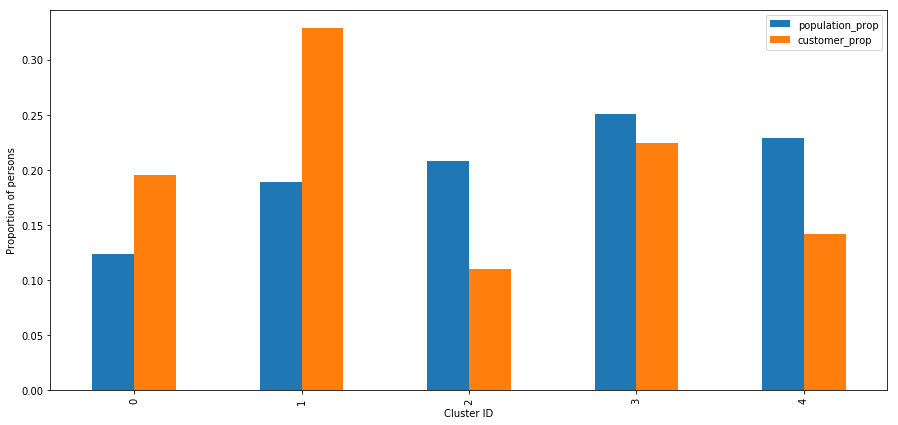

In [162]:
population_all.plot(x='k', y=['population_prop', 'customer_prop'], kind='bar', figsize=(15, 7))
plt.xlabel('Cluster ID')
plt.ylabel('Proportion of persons')
plt.show()

In [170]:
# Cluster 1
c1 = kmeans_cus.cluster_centers_[1]
c1 = pd.Series(c1)
c1.sort_values(ascending=False, inplace=True)
c1.head(5)

15    0.735993
0     0.640682
2     0.590275
16    0.489370
37    0.469371
dtype: float64

In [177]:
print(customers_clean.columns[15])
print(customers_clean.columns[0])
print(customers_clean.columns[2])
print(customers_clean.columns[16])
print(customers_clean.columns[37])

SEMIO_VERT
ALTERSKATEGORIE_GROB
FINANZ_MINIMALIST
SEMIO_LUST
KBA05_ANTG1


In [180]:
c0 = kmeans_cus.cluster_centers_[0]
c0 = pd.Series(c0)
c0.sort_values(ascending=False, inplace=True)
c0.head(5)

1     1.464398
22    1.200273
20    1.079468
17    1.009767
21    0.931987
dtype: float64

In [182]:
print(customers_clean.columns[1])
print(customers_clean.columns[22])
print(customers_clean.columns[20])
print(customers_clean.columns[17])
print(customers_clean.columns[21])

RETOURTYP_BK_S
SEMIO_KAEM
SEMIO_KRIT
SEMIO_ERL
SEMIO_DOM


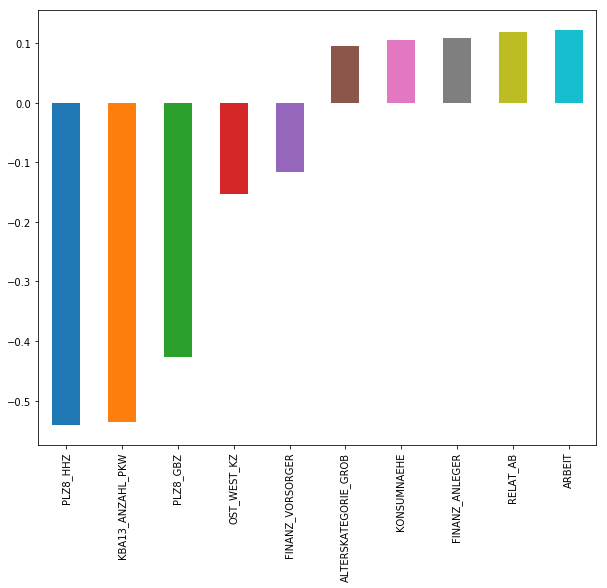

10 most weighted feature in the first component:
PLZ8_HHZ           -0.5408
KBA13_ANZAHL_PKW   -0.5362
PLZ8_GBZ           -0.4274
OST_WEST_KZ        -0.1530
FINANZ_VORSORGER   -0.1169
Name: 4, dtype: float64
ALTERSKATEGORIE_GROB    0.0954
KONSUMNAEHE             0.1055
FINANZ_ANLEGER          0.1083
RELAT_AB                0.1181
ARBEIT                  0.1228
Name: 4, dtype: float64


In [168]:
p0_cus = pca_weights(customers_clean, pca_cus, 0)

print("10 most weighted feature in the first component:")
print(p0_cus.head(5))
print(p0_cus.tail(5))

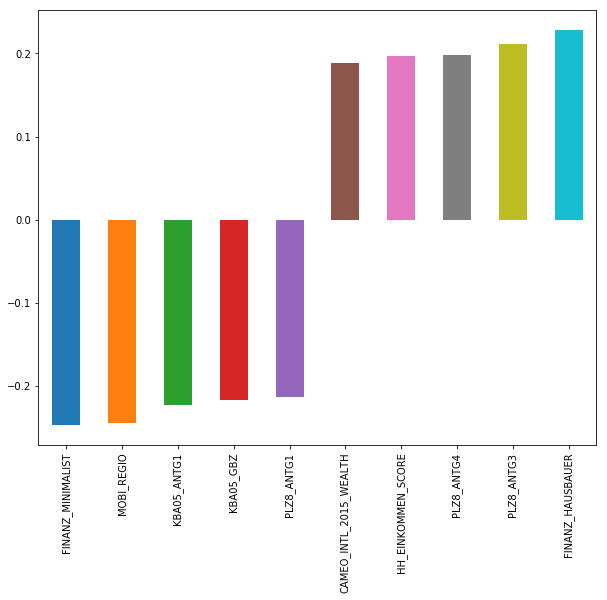

10 most weighted feature in the first component:
FINANZ_MINIMALIST   -0.2475
MOBI_REGIO          -0.2451
KBA05_ANTG1         -0.2235
KBA05_GBZ           -0.2164
PLZ8_ANTG1          -0.2132
Name: 0, dtype: float64
CAMEO_INTL_2015_WEALTH    0.1882
HH_EINKOMMEN_SCORE        0.1964
PLZ8_ANTG4                0.1985
PLZ8_ANTG3                0.2114
FINANZ_HAUSBAUER          0.2280
Name: 0, dtype: float64


In [163]:
p1_cus = pca_weights(customers_clean, pca_cus, 1)

print("10 most weighted feature in the second component:")
print(p1_cus.head(5))
print(p1_cus.tail(5))

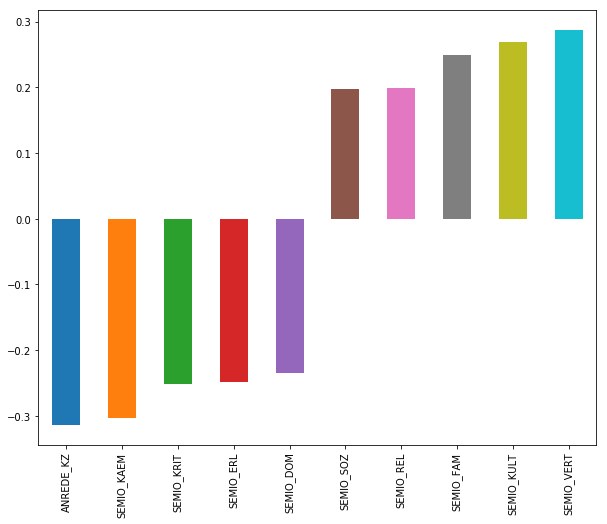

10 most weighted feature in the third component:
ANREDE_KZ    -0.3138
SEMIO_KAEM   -0.3024
SEMIO_KRIT   -0.2519
SEMIO_ERL    -0.2484
SEMIO_DOM    -0.2348
Name: 1, dtype: float64
SEMIO_SOZ     0.1971
SEMIO_REL     0.1995
SEMIO_FAM     0.2492
SEMIO_KULT    0.2688
SEMIO_VERT    0.2876
Name: 1, dtype: float64


In [169]:
p2_cus = pca_weights(customers_clean, pca_cus, 2)

print("10 most weighted feature in the third component:")
print(p2_cus.head(5))
print(p2_cus.tail(5))

In [143]:
pca_cus

PCA(copy=True, iterated_power='auto', n_components=5, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

#What kinds of people are part of a cluster that is overrepresented in the
#customer data compared to the general population?

Based on the obervation, we can see various features are playing major role in representing customer data, including Personality typology, Estimated age based on names, financial topology, property type and so on. This shows in the Cluster 1. When looking the first component, customer data showed very heavy weight on PLZ8 macro-cell features. This is a difference standing out when compare to the general population because in general population micro-cell playoed more significant role in distinguish customber groups. Macro-cell feature may have been overrepresented compareto general population. 

When looking the Cluster 0, people-level features get more weight, which is a similar pattern oberrved in the general population, indicating personal features like gender, personality etc is still very important to understand both customer and general population. 

Considering GREEN_AVANTGARDE and PRAEGENDE_JUGENDJAHRE was such a strong feature for general population, it may be underrepresented. 




### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

Customer PCA analysis indicates that mail-order company is popular in PLZ8 regions especially among smaller household size, and smaller household count regions. Noticible interest is also observed from higher affinity customers. However it seems to be less hindered by postal location. 

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.